In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#VAE Implementation for Image Generation:
# Hyperparameters
latent_dim = 64
hidden_dim = 256
batch_size = 64
lr = 0.002
epochs = 30

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.0], [1.0])])
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) #loading the dataset

# Encoder layers
fc1 = nn.Linear(28 * 28, hidden_dim).to(device)
fc_mu = nn.Linear(hidden_dim, latent_dim).to(device)
fc_logvar = nn.Linear(hidden_dim, latent_dim).to(device)

#Decoder layers
fc2 = nn.Linear(latent_dim, hidden_dim).to(device)
fc4 = nn.Linear(hidden_dim, hidden_dim).to(device)
fc3 = nn.Linear(hidden_dim, 28 * 28).to(device)

def encode(x):
    h = torch.relu(fc1(x))
    mu = fc_mu(h)
    logvar = fc_logvar(h)
    return mu, logvar

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def decode(z):
    h = torch.relu(fc2(z))
    x_recon = torch.sigmoid(fc3(h)) 
    return x_recon

optimizer = optim.Adam(list(fc1.parameters()) + list(fc_mu.parameters()) + list(fc_logvar.parameters()) + list(fc2.parameters()) + list(fc3.parameters()), lr=lr) #ADAM optimizer

#Defining the loss function 
def vae_loss(recon_x, x, mu, logvar):  
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss - using mean sqaured error
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL Divergence
    return recon_loss + kl_div, recon_loss, kl_div

ELBO_losses = []
recon_losses = []
kl_losses = []

#Traing the VAE
for epoch in range(epochs):
    total_elbo_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1).to(device)

        mu, logvar = encode(imgs)
        z = reparameterize(mu, logvar)
        recon_imgs = decode(z)

        elbo_loss, recon_loss, kl_loss = vae_loss(recon_imgs, imgs, mu, logvar)

        optimizer.zero_grad()
        elbo_loss.backward()  #backward pass
        optimizer.step()

        total_elbo_loss += elbo_loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    avg_elbo_loss = total_elbo_loss / len(dataset)
    avg_recon_loss = total_recon_loss / len(dataset)
    avg_kl_loss = total_kl_loss / len(dataset)
    ELBO_losses.append(avg_elbo_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)

    print(f"Epoch [{epoch+1}/{epochs}]  ELBO Loss: {avg_elbo_loss:.4f}  Recon Loss: {avg_recon_loss:.4f}  KL Loss: {avg_kl_loss:.4f}")



Epoch [1/30]  ELBO Loss: 42.6891  Recon Loss: 35.6780  KL Loss: 7.0111
Epoch [2/30]  ELBO Loss: 34.6425  Recon Loss: 24.5890  KL Loss: 10.0536
Epoch [3/30]  ELBO Loss: 33.0112  Recon Loss: 22.2168  KL Loss: 10.7945
Epoch [4/30]  ELBO Loss: 32.2915  Recon Loss: 21.1408  KL Loss: 11.1508
Epoch [5/30]  ELBO Loss: 31.9244  Recon Loss: 20.5787  KL Loss: 11.3457
Epoch [6/30]  ELBO Loss: 31.5972  Recon Loss: 20.1335  KL Loss: 11.4637
Epoch [7/30]  ELBO Loss: 31.3868  Recon Loss: 19.8506  KL Loss: 11.5362
Epoch [8/30]  ELBO Loss: 31.2088  Recon Loss: 19.6339  KL Loss: 11.5749
Epoch [9/30]  ELBO Loss: 31.0544  Recon Loss: 19.4549  KL Loss: 11.5995
Epoch [10/30]  ELBO Loss: 30.9066  Recon Loss: 19.3015  KL Loss: 11.6052
Epoch [11/30]  ELBO Loss: 30.7939  Recon Loss: 19.1548  KL Loss: 11.6391
Epoch [12/30]  ELBO Loss: 30.7013  Recon Loss: 19.0390  KL Loss: 11.6623
Epoch [13/30]  ELBO Loss: 30.6148  Recon Loss: 18.9495  KL Loss: 11.6653
Epoch [14/30]  ELBO Loss: 30.5591  Recon Loss: 18.8515  KL Lo

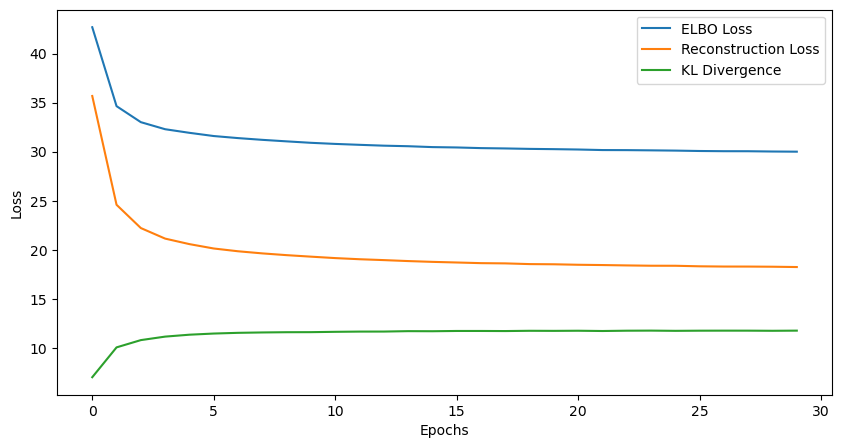

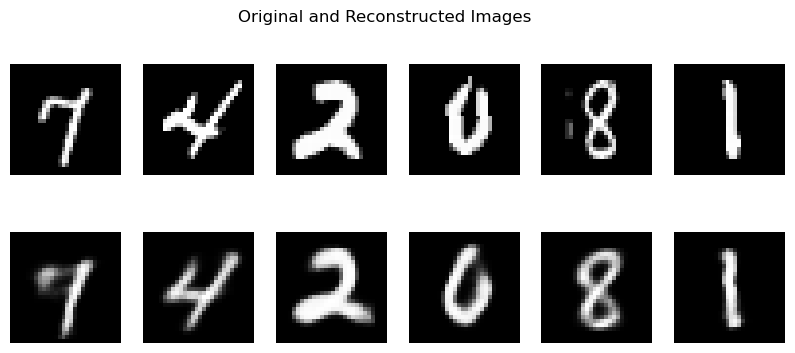

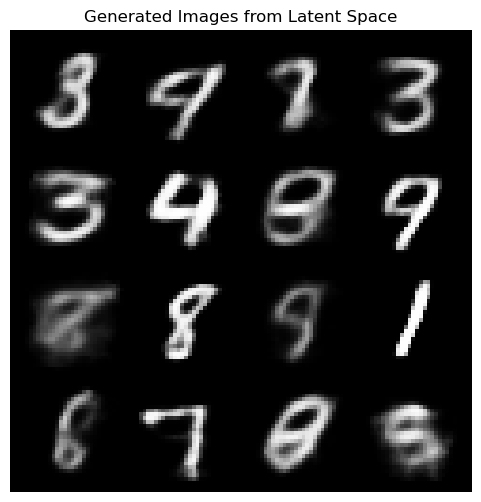

In [4]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(ELBO_losses, label="ELBO Loss")
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(kl_losses, label="KL Divergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Visualising Original and reconstructed images
with torch.no_grad():
    imgs, _ = next(iter(dataloader))
    imgs = imgs.view(imgs.size(0), -1).to(device)
    mu, logvar = encode(imgs)
    z = reparameterize(mu, logvar)
    recon_imgs = decode(z)
    recon_imgs = recon_imgs.view(recon_imgs.size(0), 1, 28, 28).cpu()
    imgs = imgs.view(imgs.size(0), 1, 28, 28).cpu()

    plt.figure(figsize=(10, 4))
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        plt.imshow(imgs[i].squeeze(0), cmap='gray')  # Original images
        plt.axis('off')
        plt.subplot(2, 6, i + 7)
        plt.imshow(recon_imgs[i].squeeze(0), cmap='gray')   # Reconstructed images
        plt.axis('off')
    plt.suptitle("Original and Reconstructed Images")
    plt.show()

    z = torch.randn(16, latent_dim).to(device)  #latent vector
    generated_imgs = decode(z).view(-1, 1, 28, 28).cpu()  # Generating new images by sampling from the latent space

    plt.figure(figsize=(6,6))
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, padding=2, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title("Generated Images from Latent Space")
    plt.axis("off")
    plt.show()


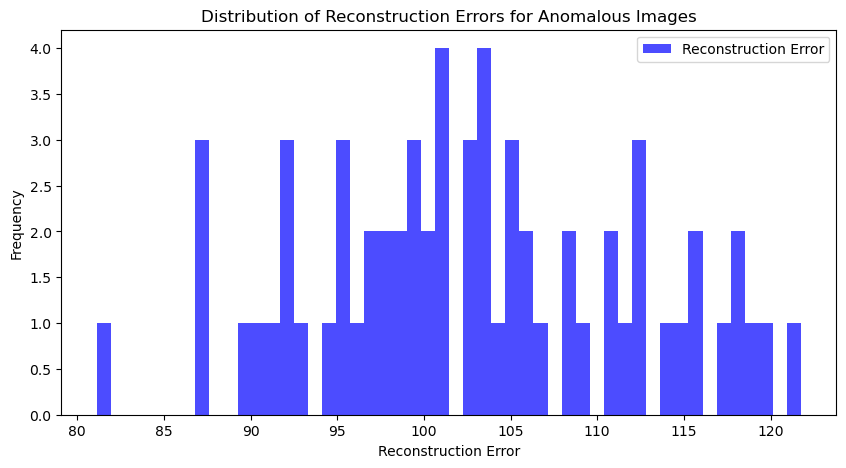

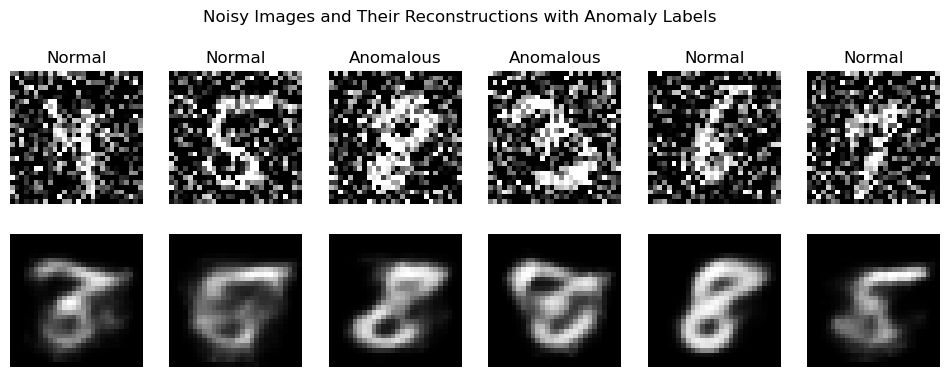

In [5]:
#VAE for Anomaly Detection
with torch.no_grad():
    imgs, _ = next(iter(dataloader))
    imgs = imgs.view(imgs.size(0), -1).to(device)
    noisy_imgs = imgs + 0.5 * torch.randn_like(imgs).to(device)  # Adding noise to create anomalies
    noisy_imgs = torch.clamp(noisy_imgs, 0.0, 1.0)  

    mu, logvar = encode(noisy_imgs)
    z = reparameterize(mu, logvar)
    recon_imgs = decode(z)

    reconstruction_errors = torch.sum((noisy_imgs - recon_imgs) ** 2, dim=1).cpu().numpy()  #calculating reconstruction error

    # Plotting the distribution of reconstruction error
    plt.figure(figsize=(10, 5))
    plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='b', label='Reconstruction Error')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Reconstruction Errors for Anomalous Images')
    plt.legend()
    plt.show()

    threshold = np.percentile(reconstruction_errors, 90)  # Setting the threshold for anomaly detection 90th percentile 

    anomaly_labels = reconstruction_errors > threshold  #classification

    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(3, 6, i + 1)
        plt.imshow(noisy_imgs[i].view(28, 28).cpu(), cmap='gray') # Original noisy images
        plt.title("Anomalous" if anomaly_labels[i] else "Normal")
        plt.axis('off')
        plt.subplot(3, 6, i + 7)
        plt.imshow(recon_imgs[i].view(28, 28).cpu(), cmap='gray')   # Reconstructed images
        plt.axis('off')
    plt.suptitle("Noisy Images and Their Reconstructions with Anomaly Labels")
    plt.show()

In [6]:
latent_vectors = []
labels = []
with torch.no_grad():
    for imgs, lbls in dataloader:
        imgs = imgs.view(imgs.size(0), -1).to(device)
        mu, _ = encode(imgs)
        latent_vectors.append(mu.cpu().numpy())
        labels.append(lbls.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)  # Reducing the latent space to 2D using t-SNE
latent_2d = tsne.fit_transform(latent_vectors)



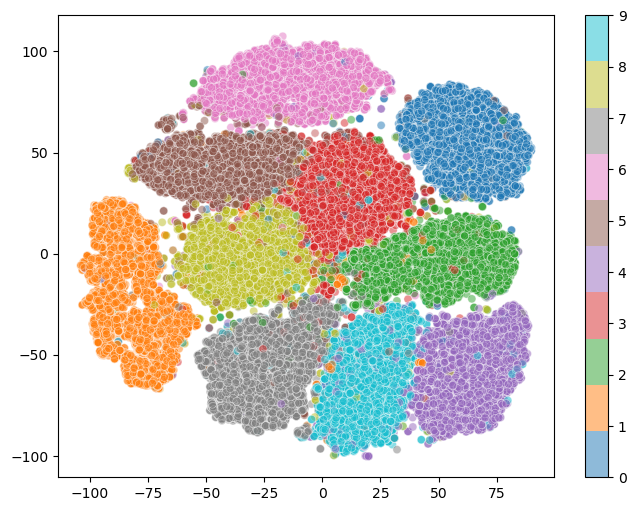

In [7]:
plt.figure(figsize=(8, 6))   # Plotting 2D latent space
scatter = plt.scatter(
    latent_2d[:, 0], 
    latent_2d[:, 1], 
    c=labels, 
    cmap='tab10', 
    alpha=0.5, 
    s=35,  # Marker size
    edgecolors='w',  # White border for better separation
    linewidth=0.5)
plt.colorbar(scatter, ticks=range(10))
